I want to try to use a Graph Neural Network to use the data from the connectome matrix separate from any other data.

In [177]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader


In [178]:
# Use read_excel and use participant_id as the index
train_cat = pd.read_excel("../data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_func = pd.read_csv(
    "../data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
)
train_quant = pd.read_excel("../data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_soln = pd.read_excel("../data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [179]:
Basic_Demos_Study_Site = {
    1: "Staten Island",
    2: "MRV",
    3: "Midtown",
    4: "Harlem",
    5: "SI RUMC",
}

PreInt_Demos_Fam_Child_Ethnicity = {
    0: "Not Hispanic or Latino",
    1: "Hispanic or Latino",
    2: "Decline to specify",
    3: "Unknown",
}

PreInt_Demos_Fam_Child_Race = {
    0: "White/Caucasian",
    1: "Black/African American",
    2: "Hispanic",
    3: "Asian",
    4: "Indian",
    5: "Native American Indian",
    6: "American Indian/Alaskan Native",
    7: "Native Hawaiian/Other Pacific Islander",
    8: "Two or more races",
    9: "Other race",
    10: "Unknown",
    11: "Chose not to specify",
}

MRI_Track_Scan_Location = {1: "Staten Island", 2: "RUBIC", 3: "CBIC", 4: "CUNY"}

Barratt_Barratt_P1_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree",
}

Barratt_Barratt_P1_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}

Barratt_Barratt_P2_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree",
}

Barratt_Barratt_P2_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}

In [180]:
# Apply label replacements using the dictionaries
train_cat["Basic_Demos_Study_Site"] = train_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
train_cat["PreInt_Demos_Fam_Child_Race"] = train_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
train_cat["MRI_Track_Scan_Location"] = train_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
train_cat["Barratt_Barratt_P1_Edu"] = train_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
train_cat["Barratt_Barratt_P1_Occ"] = train_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
train_cat["Barratt_Barratt_P2_Edu"] = train_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
train_cat["Barratt_Barratt_P2_Occ"] = train_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

In [181]:
# One-hot encode all columns except 'participant_id' and 'Basic_Demos_Enroll_Year'
train_cat_encoded = pd.get_dummies(
    train_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,  # Optional: adds a column for NaNs if present
    drop_first=False,  # Set to True if you want to drop the first category to avoid multicollinearity
)

# Check the result
train_cat_encoded.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,...,"Barratt_Barratt_P2_Occ_Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.","Barratt_Barratt_P2_Occ_Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.","Barratt_Barratt_P2_Occ_Homemaker, stay at home parent.","Barratt_Barratt_P2_Occ_Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.","Barratt_Barratt_P2_Occ_Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.","Barratt_Barratt_P2_Occ_Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.","Barratt_Barratt_P2_Occ_Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.","Barratt_Barratt_P2_Occ_Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.","Barratt_Barratt_P2_Occ_Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",Barratt_Barratt_P2_Occ_nan
0,00aIpNTbG5uh,2019,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,00fV0OyyoLfw,2017,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,04X1eiS79T4B,2017,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,05ocQutkURd6,2018,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,06YUNBA9ZRLq,2018,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [182]:
# Deal with NaN values
train_quant = train_quant.fillna(train_quant.drop("participant_id", axis=1).mean())
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [186]:
# Save participant IDs before dropping the column
train_func_ids = train_func["participant_id"]

# Drop participant_id from features before splitting
train_func_no_id = train_func.drop(columns=["participant_id"])

# Target labels
y_sex = train_soln["Sex_F"]
y_adhd = train_soln["ADHD_Outcome"]

# Split features and labels
X_train, X_val, y_train_adhd, y_val_adhd = train_test_split(
    train_func_no_id, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd
)

# Use the saved participant IDs to track train/val split
train_func_ids_train = train_func_ids.loc[X_train.index].values
train_func_ids_val = train_func_ids.loc[X_val.index].values

## Step 1: convert connectome matrix back into symmetric matrix
- Nodes: brain regions
- Edges: weighted by correlations between regions

In [187]:
def vector_to_symmetric_matrix(upper_tri_vector, n_nodes):
    """
    Convert a 1D array representing the upper triangle of a symmetric matrix
    (excluding the diagonal) back into a full symmetric matrix.

    Args:
        upper_tri_vector (np.array): Flattened upper triangle (length = n_nodes * (n_nodes - 1) / 2)
        n_nodes (int): Number of nodes in the original matrix

    Returns:
        np.array: n_nodes x n_nodes symmetric matrix
    """
    # Initialize empty symmetric matrix
    mat = np.zeros((n_nodes, n_nodes))

    # Get upper triangle indices (excluding diagonal)
    upper_tri_indices = np.triu_indices(n_nodes, k=1)

    # Fill in upper triangle
    mat[upper_tri_indices] = upper_tri_vector

    # Mirror to lower triangle
    mat[(upper_tri_indices[1], upper_tri_indices[0])] = upper_tri_vector

    return mat

In [189]:
# Create the adjacency matrices for the training set
train_matrices = []
valid_matrices = []

for i in range(len(X_train)):
    row_vector = X_train.iloc[i].astype(float).values
    matrix = vector_to_symmetric_matrix(row_vector, n_nodes=200)
    train_matrices.append(matrix)

for i in range(len(X_val)):
    valid_vector = X_val.iloc[i].astype(float).values
    valid_mat = vector_to_symmetric_matrix(valid_vector, n_nodes=200)
    valid_matrices.append(valid_mat)

# Convert to NumPy array if needed
train_matrices = np.array(train_matrices)
valid_matrices = np.array(valid_matrices)

Ok, now each person's functional MRI data has been converted back into this matrix, which we can visualize as a heatmap to see brain activity!

<Axes: >

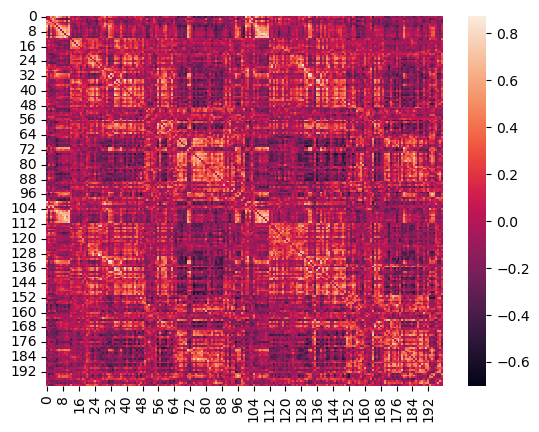

In [190]:
sns.heatmap(train_matrices[0])

In [191]:
def create_graph_from_matrix(adj_matrix, labels=y_adhd):
    # Create edge_index from non-zero elements of the adjacency matrix
    edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)

    # Create edge_attr from the non-zero values of the adjacency matrix
    edge_attr = torch.tensor(adj_matrix[adj_matrix != 0], dtype=torch.float)

    # Use an identity matrix as node features (this can be customized later)
    x = torch.eye(adj_matrix.shape[0], dtype=torch.float)  # identity node features

    # If labels are provided, ensure they are in a tensor form, and add to Data object
    if labels is not None:
        y = torch.tensor(
            labels, dtype=torch.long
        )  # Assuming binary labels or regression targets
    else:
        y = None  # If no labels are provided, y will be None

    # Return a Data object with node features, edge index, edge attributes, and labels (if available)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [194]:
train_data_objs = []
valid_objs = []

for i in range(len(train_matrices)):
    label = int(y_train_adhd.iloc[i])  # Accessing y_train_adhd with correct index
    train_data_objs.append(create_graph_from_matrix(train_matrices[i], labels=label))

for i in range(len(valid_matrices)):
    valid_objs.append(create_graph_from_matrix(valid_matrices[i], labels = y_val_adhd.iloc[i]))

train_loader = DataLoader(
    train_data_objs, batch_size=32, shuffle=True
)  # Adjust batch size as needed

valid_loader = DataLoader(
    valid_objs, batch_size=32, shuffle=True
)


/opt/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [195]:
class BrainGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BrainGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.pool = global_mean_pool  # can also try global_max_pool

        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        # Batch each Data object using DataLoader
        x, edge_index, edge_attr, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.batch,
        )

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.pool(x, batch)
        return self.fc(x)

In [ ]:
# Initialize the model, loss function, and optimizer
model = BrainGNN(
    in_channels=200, hidden_channels=64, out_channels=2
)  # 2 for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Use BCEWithLogitsLoss for binary classification

# Train loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)  # Forward pass
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

In [ ]:
def evaluate(model, valid_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation (no need for backprop during evaluation)
        for data in valid_loader:
            output = model(data)  # Get the model's predictions

            # Get the predicted class (for binary classification, we use argmax)
            _, preds = torch.max(output, dim=1)  # Predicted class indices

            all_preds.extend(preds.cpu().numpy())  # Store the predictions
            all_labels.extend(data.y.cpu().numpy())  # Store the true labels

    # Calculate accuracy (or other metrics if needed)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return accuracy, f1, recall

In [ ]:
evaluate(model, valid_loader)

(0.6831275720164609, 0.8117359413202934, 1.0)